# QXMT-SLAM: Quantum-Inspired Cross-Modal Transformer for Multi-Modal Lunar Odometry

Camera (EfficientNet-B0) + LiDAR (PointNet-style) + IMU (MLP)

Novel fusion: **Quantum-Inspired Projection + Cross-Modal Transformer + Temporal LSTM**

Supports **Moon_1 ... Moon_n** automatically.

In [1]:
import os, sys, math
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
torch.set_float32_matmul_precision("high")

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from tqdm import tqdm

project_src = Path("~/experiment/src").expanduser()
sys.path.append(str(project_src))
from lusnar_dataset import LuSNARDataset

plt.rcParams["figure.dpi"] = 120
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# === Helper functions for IMU alignment and LiDAR loading ===

def build_imu_for_color_ts(imu_table, color_ts):
    """Align IMU to camera frames by nearest timestamp.
    imu_table: (M, K) with imu_table[:,0] = timestamp, rest = IMU channels.
    color_ts: (N,) camera timestamps (int64).
    Returns: imu_per_color: (N, C_imu) float32.
    Assumes 6 IMU channels: ax,ay,az,gx,gy,gz.
    """
    imu_table = np.asarray(imu_table)
    imu_ts = imu_table[:, 0].astype(np.int64)
    imu_data = imu_table[:, 1:7].astype(np.float32)

    imu_per_color = np.zeros((len(color_ts), imu_data.shape[1]), dtype=np.float32)
    for i, ts in enumerate(color_ts):
        ts = int(ts)
        idx = np.searchsorted(imu_ts, ts)
        if idx <= 0:
            nearest = 0
        elif idx >= len(imu_ts):
            nearest = len(imu_ts) - 1
        else:
            before = imu_ts[idx - 1]
            after = imu_ts[idx]
            nearest = idx if abs(after - ts) < abs(before - ts) else idx - 1
        imu_per_color[i] = imu_data[nearest]
    return imu_per_color


def load_lidar_points(lidar_dir, ts_int):
    """
    Load LiDAR point cloud for a given timestamp.
    Supports comma-separated or space-separated files.
    Ignores intensity/label columns and keeps XYZ only.
    """
    lidar_path = Path(lidar_dir) / f"{int(ts_int)}.txt"
    if not lidar_path.exists():
        return np.zeros((0, 3), dtype=np.float32)

    try:
        # Read raw text
        with open(lidar_path, "r") as f:
            lines = f.readlines()

        pts_list = []
        for line in lines:
            line = line.strip()
            if not line:
                continue

            # Detect comma or space
            if "," in line:
                parts = line.split(",")
            else:
                parts = line.split()

            # At least x,y,z must be present
            if len(parts) < 3:
                continue

            # Convert first 3 numbers to float
            try:
                x, y, z = float(parts[0]), float(parts[1]), float(parts[2])
                pts_list.append([x, y, z])
            except:
                continue

        if len(pts_list) == 0:
            return np.zeros((0, 3), dtype=np.float32)

        return np.array(pts_list, dtype=np.float32)

    except Exception as e:
        print(f"[WARN] Could not parse LiDAR file {lidar_path}: {e}")
        return np.zeros((0, 3), dtype=np.float32)


print("Helper functions ready.")

Helper functions ready.


In [3]:
DATA_ROOT_PARENT = Path("~/experiment/dataset").expanduser()

moon_dirs = sorted([
    d for d in DATA_ROOT_PARENT.iterdir()
    if d.is_dir() and d.name.lower().startswith("moon_")
])

if not moon_dirs:
    raise RuntimeError(f"No Moon_* datasets found under {DATA_ROOT_PARENT}")

print("Detected Moon datasets:")
for d in moon_dirs:
    print(" -", d.name)

datasets = []          # list[LuSNARDataset]
all_color_ts = []      # list[np.ndarray] per dataset
all_t_gt = []          # list[np.ndarray] per dataset, shape (N_i,3)
all_imu_feats = []     # list[np.ndarray] per dataset, shape (N_i,6)

for d in moon_dirs:
    print(f"\n[LuSNAR] Loading {d.name} ...")
    ds = LuSNARDataset(d)
    datasets.append(ds)

    gt = ds.gt.astype(np.float64)
    gt_xyz = gt[:, 1:4]                     # (N_i,3)
    color_ts = ds.color_ts.astype(np.int64) # (N_i,)

    # Ensure equal length between timestamps and GT
    N_i = min(len(color_ts), gt_xyz.shape[0])
    color_ts = color_ts[:N_i]
    gt_xyz = gt_xyz[:N_i]

    # Align IMU to camera frames
    imu_table = ds.imu  # ds.imu: first col timestamp, others IMU channels
    imu_feats = build_imu_for_color_ts(imu_table, color_ts)

    all_color_ts.append(color_ts)
    all_t_gt.append(gt_xyz)
    all_imu_feats.append(imu_feats)

    print(f"  Frames: {N_i}")
    print(f"  GT shape: {gt_xyz.shape}")
    print(f"  Color timestamps shape: {color_ts.shape}")
    print(f"  IMU per-frame features: {imu_feats.shape}")

# Concatenate all trajectories only for global statistics / plotting
t_gt_all = np.concatenate(all_t_gt, axis=0)
print("\nTotal frames across all Moon_* datasets:", t_gt_all.shape[0])

Detected Moon datasets:
 - Moon_1
 - Moon_2
 - Moon_3
 - Moon_4
 - Moon_5
 - Moon_6
 - Moon_7
 - Moon_8

[LuSNAR] Loading Moon_1 ...
[LuSNAR] Loaded 1094 frames.
  Frames: 1094
  GT shape: (1094, 3)
  Color timestamps shape: (1094,)
  IMU per-frame features: (1094, 6)

[LuSNAR] Loading Moon_2 ...
[LuSNAR] Loaded 1597 frames.
  Frames: 1597
  GT shape: (1597, 3)
  Color timestamps shape: (1597,)
  IMU per-frame features: (1597, 6)

[LuSNAR] Loading Moon_3 ...
[LuSNAR] Loaded 1230 frames.
  Frames: 1230
  GT shape: (1230, 3)
  Color timestamps shape: (1230,)
  IMU per-frame features: (1230, 6)

[LuSNAR] Loading Moon_4 ...
[LuSNAR] Loaded 1320 frames.
  Frames: 1320
  GT shape: (1320, 3)
  Color timestamps shape: (1320,)
  IMU per-frame features: (1320, 6)

[LuSNAR] Loading Moon_5 ...
[LuSNAR] Loaded 1599 frames.
  Frames: 1599
  GT shape: (1599, 3)
  Color timestamps shape: (1599,)
  IMU per-frame features: (1599, 6)

[LuSNAR] Loading Moon_6 ...
[LuSNAR] Loaded 1102 frames.
  Frames: 110

In [4]:
# === QXMT-SLAM config & GT normalization (over ALL datasets) ===
IMG_SIZE = 320          # keep native camera resolution
SEQ_LEN = 5              # number of Δt steps per training sample (T = SEQ_LEN+1)
N_POINTS = 4096          # LiDAR points sampled per frame (higher for GPU load)

# Quantum-Inspired Projection dimensions
CAM_FEAT_DIM = 256       # camera feature dim
QIP_DIM = 64             # quantum-inspired projected dim
LIDAR_FEAT_DIM = 128     # LiDAR global feature dim
IMU_FEAT_DIM = 32        # IMU feature dim
D_MODEL = 256            # transformer model dim
N_HEADS = 4              # transformer heads
N_XM_LAYERS = 2          # # of cross-modal transformer layers
LSTM_HIDDEN = 128        # BiLSTM hidden size per direction

# Normalize scale of translations to stabilize training (global stats)
t_mean = t_gt_all.mean(axis=0).astype(np.float32)
t_std = t_gt_all.std(axis=0).astype(np.float32) + 1e-6  # avoid divide-by-zero

print("Global t_mean:", t_mean)
print("Global t_std:", t_std)
print("Total frames across all datasets:", t_gt_all.shape[0])

Global t_mean: [ 9.6017426e+01 -3.2015499e+01 -3.8515609e-02]
Global t_std: [60.750668   56.876663    0.80968904]
Total frames across all datasets: 10919


In [5]:
def translation_rmse(pred, gt):
    """Compute translation RMSE (in meters)."""
    diff = pred - gt
    err = np.linalg.norm(diff, axis=1)
    return float(np.sqrt(np.mean(err ** 2))), err

def step_rmse(pred_dt, gt_dt):
    """RMSE over step-wise translations Δt."""
    diff = pred_dt - gt_dt
    err = np.linalg.norm(diff, axis=1)
    return float(np.sqrt(np.mean(err ** 2))), err

def trajectory_length(gt):
    """Total path length of ground-truth trajectory."""
    if gt.shape[0] < 2:
        return 0.0, np.array([])
    diffs = gt[1:] - gt[:-1]
    seg = np.linalg.norm(diffs, axis=1)
    return float(np.sum(seg)), seg

print("Metric helpers ready.")

Metric helpers ready.


Img tensor shape (C,H,W): torch.Size([3, 320, 320])


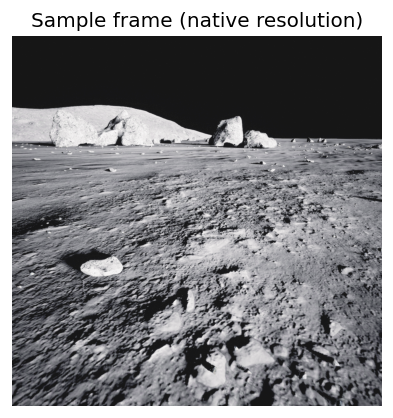

In [6]:
# Image preprocessing helper (BGR from OpenCV -> torch tensor)
def preprocess_image_bgr_to_tensor(rgb_bgr):
    """Input: BGR image (H,W,3).
    If IMG_SIZE is not None, resize to (IMG_SIZE, IMG_SIZE),
    otherwise keep native resolution.
    Output: float tensor (3, H, W) in [0,1].
    """
    rgb = cv2.cvtColor(rgb_bgr, cv2.COLOR_BGR2RGB)
    if IMG_SIZE is not None:
        rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    rgb = rgb.astype(np.float32) / 255.0
    # (H,W,3) -> (3,H,W)
    rgb = np.transpose(rgb, (2, 0, 1))
    return torch.from_numpy(rgb)

# Quick sanity check and visualization: use first frame of first dataset
rgb0 = datasets[0].load_rgb(int(all_color_ts[0][0]))
img_t = preprocess_image_bgr_to_tensor(rgb0)

print("Img tensor shape (C,H,W):", img_t.shape)

plt.figure(figsize=(5, 4))
plt.imshow(cv2.cvtColor(rgb0, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Sample frame (native resolution)")
plt.show()

In [7]:
class QuantumInspiredProjection(nn.Module):
    """Quantum-Inspired Projection (QIP)
    Takes camera feature f ∈ R^{C} and maps to q ∈ R^{QIP_DIM} using
    a unitary-like mixing (linear + sin/cos nonlinearity) with residual.
    This is fully GPU-based and differentiable.
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc_theta = nn.Linear(in_dim, out_dim)
        self.fc_phi = nn.Linear(in_dim, out_dim)
        self.res = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        # x: (B*T, in_dim)
        theta = self.fc_theta(x)  # (B*T, out_dim)
        phi = self.fc_phi(x)      # (B*T, out_dim)
        # quantum-like rotation embedding
        s = torch.sin(theta)
        c = torch.cos(phi)
        mixed = s * c
        return mixed + self.res(x)


class SimplePointNet(nn.Module):
    """Simple PointNet-style encoder for LiDAR point clouds.
    Input: (B, N_POINTS, 3) -> Output: (B, LIDAR_FEAT_DIM)
    """
    def __init__(self, input_dim=3, emb_dims=LIDAR_FEAT_DIM):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, emb_dims),
            nn.ReLU(inplace=True),
        )
        self.emb_dims = emb_dims

    def forward(self, x):
        # x: (B, N, 3)
        B, N, C = x.shape
        x_flat = x.view(B * N, C)
        feat = self.mlp(x_flat)               # (B*N, emb_dims)
        feat = feat.view(B, N, self.emb_dims) # (B, N, emb_dims)
        feat = feat.max(dim=1).values        # (B, emb_dims) global max-pool
        return feat


class IMUEncoder(nn.Module):
    """IMU encoder using a small MLP.
    Input: 6D IMU (ax,ay,az,gx,gy,gz) -> IMU_FEAT_DIM.
    """
    def __init__(self, in_dim=6, out_dim=IMU_FEAT_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, out_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # x: (B, in_dim)
        return self.net(x)


class QXMTSLAMNet(nn.Module):
    """QXMT-SLAM: Quantum-Inspired Cross-Modal Transformer Odometry.

    Modalities:
      - Camera: EfficientNet-B0 -> CAM_FEAT_DIM -> QIP -> QIP_DIM
      - LiDAR : PointNet -> LIDAR_FEAT_DIM
      - IMU   : MLP -> IMU_FEAT_DIM

    Cross-modal fusion:
      - Map each modality feature to D_MODEL, treat them as 3 tokens
      - Cross-modal Transformer encoder (N_XM_LAYERS)
      - Fuse tokens per timestep (mean) -> fused_feat_t
      - Temporal BiLSTM over fused sequence
      - Head regresses Δt (x,y,z) per step, normalized by t_std

    Input:
      img_seq  : (B, T, 3, H, W)
      lidar_seq: (B, T, N_POINTS, 3)
      imu_seq  : (B, T, 6)

    Output:
      dt_norm  : (B, T-1, 3)  (normalized Δt)
    """
    def __init__(self,
                 cam_feat_dim=CAM_FEAT_DIM,
                 qip_dim=QIP_DIM,
                 lidar_dim=LIDAR_FEAT_DIM,
                 imu_dim=IMU_FEAT_DIM,
                 d_model=D_MODEL,
                 n_heads=N_HEADS,
                 n_layers=N_XM_LAYERS,
                 lstm_hidden=LSTM_HIDDEN,
                 n_points=N_POINTS):
        super().__init__()

        # === 1. Camera Encoder (EfficientNet-B0) ===
        ef = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.cnn = ef.features  # -> (B, 1280, H/32, W/32)
        self.cam_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.cam_fc = nn.Linear(1280, cam_feat_dim)

        # === 2. Quantum-Inspired Projection (QIP) ===
        self.qip = QuantumInspiredProjection(cam_feat_dim, qip_dim)

        # === 3. LiDAR encoder ===
        self.n_points = n_points
        self.lidar_encoder = SimplePointNet(input_dim=3, emb_dims=lidar_dim)

        # === 4. IMU encoder ===
        self.imu_encoder = IMUEncoder(in_dim=6, out_dim=imu_dim)

        # === 5. Cross-modal projection to common d_model ===
        self.cam_proj = nn.Linear(qip_dim, d_model)
        self.lidar_proj = nn.Linear(lidar_dim, d_model)
        self.imu_proj = nn.Linear(imu_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=n_heads,
                                                   dim_feedforward=4*d_model,
                                                   batch_first=False,
                                                   dropout=0.1,
                                                   activation="gelu")
        self.xm_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # === 6. Temporal BiLSTM ===
        self.lstm = nn.LSTM(input_size=d_model,
                            hidden_size=lstm_hidden,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)

        # === 7. Regression head: Δt (x,y,z) ===
        self.head = nn.Sequential(
            nn.Linear(2 * lstm_hidden, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 3)
        )

    def encode_camera(self, x_seq):
        # x_seq: (B, T, 3, H, W)
        B, T, C, H, W = x_seq.shape
        x_flat = x_seq.view(B * T, C, H, W)
        feat = self.cnn(x_flat)                # (B*T,1280,h,w)
        feat = self.cam_pool(feat)             # (B*T,1280,1,1)
        feat = feat.view(B * T, -1)            # (B*T,1280)
        feat = self.cam_fc(feat)               # (B*T,CAM_FEAT_DIM)
        qip = self.qip(feat)                   # (B*T,QIP_DIM)
        qip_seq = qip.view(B, T, -1)           # (B,T,QIP_DIM)
        return qip_seq

    def encode_lidar(self, lidar_seq):
        # lidar_seq: (B, T, N_POINTS, 3)
        B, T, Np, C = lidar_seq.shape
        x_flat = lidar_seq.view(B * T, Np, C)
        feat = self.lidar_encoder(x_flat)      # (B*T,LIDAR_FEAT_DIM)
        feat_seq = feat.view(B, T, -1)         # (B,T,LIDAR_FEAT_DIM)
        return feat_seq

    def encode_imu(self, imu_seq):
        # imu_seq: (B, T, 6)
        B, T, C = imu_seq.shape
        imu_flat = imu_seq.view(B * T, C)
        feat = self.imu_encoder(imu_flat)      # (B*T,IMU_FEAT_DIM)
        feat_seq = feat.view(B, T, -1)         # (B,T,IMU_FEAT_DIM)
        return feat_seq

    def forward(self, img_seq, lidar_seq, imu_seq):
        """Forward pass.
        img_seq  : (B, T, 3, H, W)
        lidar_seq: (B, T, N_POINTS, 3)
        imu_seq  : (B, T, 6)
        Returns:
          dt_norm: (B, T-1, 3)
        """
        B, T, _, _, _ = img_seq.shape

        cam_qip = self.encode_camera(img_seq)      # (B,T,QIP_DIM)
        lidar_feat = self.encode_lidar(lidar_seq)  # (B,T,LIDAR_FEAT_DIM)
        imu_feat = self.encode_imu(imu_seq)        # (B,T,IMU_FEAT_DIM)

        # Project to common d_model
        cam_tok = self.cam_proj(cam_qip)           # (B,T,D_MODEL)
        lidar_tok = self.lidar_proj(lidar_feat)    # (B,T,D_MODEL)
        imu_tok = self.imu_proj(imu_feat)          # (B,T,D_MODEL)

        # Build 3 tokens per timestep: (B,T,3,D_MODEL)
        tokens = torch.stack([cam_tok, lidar_tok, imu_tok], dim=2)  # (B,T,3,D_MODEL)

        # Flatten time into batch for Transformer: (3, B*T, D_MODEL)
        tokens_flat = tokens.view(B * T, 3, -1).transpose(0, 1)  # (3,B*T,D_MODEL)

        # Cross-modal Transformer
        xm_out = self.xm_encoder(tokens_flat)      # (3,B*T,D_MODEL)

        # Fuse tokens per timestep (mean over 3 modalities)
        xm_out = xm_out.mean(dim=0)                # (B*T,D_MODEL)
        fused_seq = xm_out.view(B, T, -1)          # (B,T,D_MODEL)

        # Temporal BiLSTM
        lstm_out, _ = self.lstm(fused_seq)         # (B,T,2*LSTM_HIDDEN)

        # Predict Δt for transitions between frames: use steps 1..T-1
        steps = lstm_out[:, 1:, :]                 # (B,T-1,2*LSTM_HIDDEN)
        dt_norm = self.head(steps)                 # (B,T-1,3)

        return dt_norm


print("QXMT-SLAM model defined.")

QXMT-SLAM model defined.


In [8]:
class MultiModalSequenceDataset(Dataset):
    """Multi-modal sequence dataset over multiple Moon_* sequences.

    For a given dataset index ds_i and start index s, we take frames:
      s, s+1, ..., s+SEQ_LEN  (T = SEQ_LEN+1 frames)

    Input per sample:
      images   -> (T, 3, H, W)
      lidar    -> (T, N_POINTS, 3)
      imu_seq  -> (T, 6)
    Target:
      Δt_norm -> (SEQ_LEN, 3)
    """
    def __init__(self,
                 datasets,
                 color_ts_list,
                 t_gt_list,
                 imu_list,
                 t_std,
                 seq_len=SEQ_LEN,
                 n_points=N_POINTS):
        self.datasets = datasets
        self.color_ts_list = color_ts_list
        self.t_gt_list = [gt.astype(np.float32) for gt in t_gt_list]
        self.imu_list = [imu.astype(np.float32) for imu in imu_list]
        self.t_std = t_std.astype(np.float32)
        self.seq_len = seq_len
        self.n_points = n_points

        # Build a global index map: each entry (ds_idx, start_idx)
        self.index_map = []
        for ds_idx, ts in enumerate(self.color_ts_list):
            length = len(ts)
            max_start = length - (self.seq_len + 1)
            if max_start < 0:
                continue
            for s in range(max_start + 1):
                self.index_map.append((ds_idx, s))

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        ds_idx, start = self.index_map[idx]
        ds = self.datasets[ds_idx]
        ts_array = self.color_ts_list[ds_idx]
        t_array = self.t_gt_list[ds_idx]
        imu_array = self.imu_list[ds_idx]

        end = start + self.seq_len + 1          # frames [start, ..., start+SEQ_LEN]
        ts_seq = ts_array[start:end]            # length T = SEQ_LEN+1

        imgs = []
        lidars = []
        for ts in ts_seq:
            # Camera
            rgb = ds.load_rgb(int(ts))
            imgs.append(preprocess_image_bgr_to_tensor(rgb))

            # LiDAR
            pts = load_lidar_points(ds.lidar_dir, ts)
            if pts.shape[0] == 0:
                sampled = np.zeros((self.n_points, 3), dtype=np.float32)
            else:
                if pts.shape[0] >= self.n_points:
                    idxs = np.random.choice(pts.shape[0], self.n_points, replace=False)
                else:
                    idxs = np.random.choice(pts.shape[0], self.n_points, replace=True)
                sampled = pts[idxs]
            lidars.append(torch.from_numpy(sampled))

        imgs = torch.stack(imgs, dim=0)                  # (T,3,H,W)
        lidar_seq = torch.stack(lidars, dim=0)           # (T,N_POINTS,3)
        imu_seq = torch.from_numpy(imu_array[start:end]) # (T,6)

        t_seq = t_array[start:end]            # (T,3)
        dt = t_seq[1:] - t_seq[:-1]           # (SEQ_LEN,3)
        dt_norm = dt / self.t_std             # scale only

        return imgs, lidar_seq, imu_seq, torch.from_numpy(dt_norm)


# === Build sequence dataset + loaders over ALL Moon_* datasets ===
mm_seq_ds = MultiModalSequenceDataset(
    datasets=datasets,
    color_ts_list=all_color_ts,
    t_gt_list=all_t_gt,
    imu_list=all_imu_feats,
    t_std=t_std,
    seq_len=SEQ_LEN,
    n_points=N_POINTS,
)

val_ratio = 0.2
n_val = int(len(mm_seq_ds) * val_ratio)
n_train = len(mm_seq_ds) - n_val

mm_train, mm_val = random_split(mm_seq_ds, [n_train, n_val])

# Higher batch size to push GPU harder – adjust if OOM
BATCH_SIZE = 4

train_loader = DataLoader(
    mm_train, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    mm_val, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=4, pin_memory=True
)

model = QXMTSLAMNet().to(device)
model = torch.compile(model)  # Use torch.compile to further increase GPU utilization

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=3
)

print("Train/Val sizes:", len(mm_train), len(mm_val))
print("Total params (M):", sum(p.numel() for p in model.parameters()) / 1e6)

/home/gurman_preet_526_gmail_com/py310/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Train/Val sizes: 8704 2175
Total params (M): 6.460735



[QXMT-SLAM] Epoch 01/20


  0%|                                                   | 0/544 [00:00<?, ?it/s]W1201 16:53:00.469000 65773 torch/_inductor/utils.py:1613] [0/1_1] Not enough SMs to use max_autotune_gemm mode
                                                                                

  train=0.000017 | val=0.000010 | best_val=0.000010

[QXMT-SLAM] Epoch 02/20


  train=0.000004 | val=0.000005 | best_val=0.000005

[QXMT-SLAM] Epoch 03/20


  train=0.000002 | val=0.000002 | best_val=0.000002

[QXMT-SLAM] Epoch 04/20


  train=0.000002 | val=0.000002 | best_val=0.000002

[QXMT-SLAM] Epoch 05/20


  train=0.000002 | val=0.000002 | best_val=0.000002

[QXMT-SLAM] Epoch 06/20


  train=0.000001 | val=0.000001 | best_val=0.000001

[QXMT-SLAM] Epoch 07/20


  train=0.000001 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 08/20


  train=0.000001 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 09/20


  train=0.000001 | val=0.000001 | best_val=0.000000

[QXMT-SLAM] Epoch 10/20


  train=0.000001 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 11/20


  train=0.000001 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 12/20


  train=0.000000 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 13/20


  train=0.000000 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 14/20


  train=0.000000 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 15/20


  train=0.000000 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 16/20


  train=0.000000 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 17/20


  train=0.000000 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 18/20


  train=0.000000 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 19/20


  train=0.000000 | val=0.000000 | best_val=0.000000

[QXMT-SLAM] Epoch 20/20


  train=0.000000 | val=0.000000 | best_val=0.000000
Loaded best model (val MSE = 0.000000)


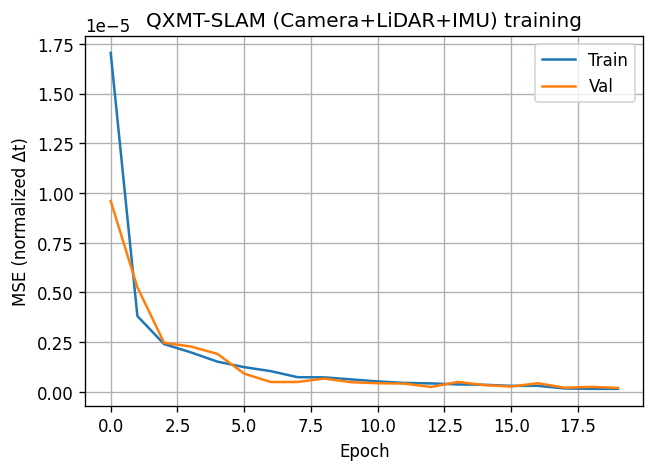

In [9]:
def run_epoch_qxmt(loader, model, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    n = 0

    for imgs, lidars, imus, yb in tqdm(loader, leave=False):
        # imgs  : (B, T, 3, H, W)
        # lidars: (B, T, N_POINTS, 3)
        # imus  : (B, T, 6)
        # yb    : (B, SEQ_LEN, 3)
        imgs = imgs.to(device, non_blocking=True)
        lidars = lidars.to(device, non_blocking=True)
        imus = imus.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if optimizer is not None:
            optimizer.zero_grad()

        pred_dt = model(imgs, lidars, imus)  # (B, SEQ_LEN, 3)
        loss = criterion(pred_dt, yb)

        if optimizer is not None:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        n += imgs.size(0)

    return total_loss / max(n, 1)


NUM_EPOCHS = 20
train_losses, val_losses = [], []
best_val = float("inf")
best_state = None

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n[QXMT-SLAM] Epoch {epoch:02d}/{NUM_EPOCHS}")
    train_loss = run_epoch_qxmt(train_loader, model, optimizer)
    val_loss = run_epoch_qxmt(val_loader, model, optimizer=None)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"  train={train_loss:.6f} | val={val_loss:.6f} | best_val={best_val:.6f}")

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print("Loaded best model (val MSE = {:.6f})".format(best_val))

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δt)")
plt.title("QXMT-SLAM (Camera+LiDAR+IMU) training")
plt.grid(True)
plt.legend()
plt.show()

=== QXMT-SLAM (Camera+LiDAR+IMU) Metrics over ALL Moon_* ===
Trajectory RMSE       : 36.40266 m
Total path length     : 3689.19294 m
Trajectory RMSE (%%)  : 0.98674 % of path length
---
Step RMSE             : 0.05107 m
Mean step length      : 0.33790 m
Step RMSE (%%)        : 15.11383 % of mean step


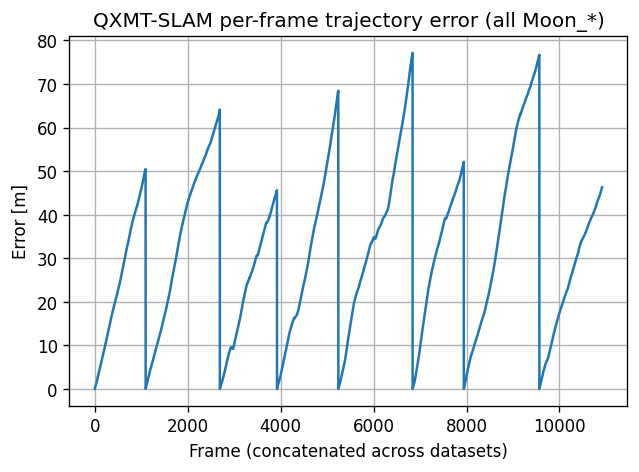

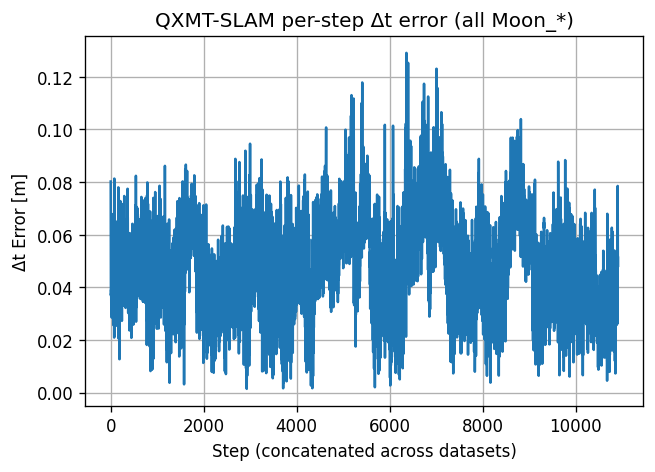

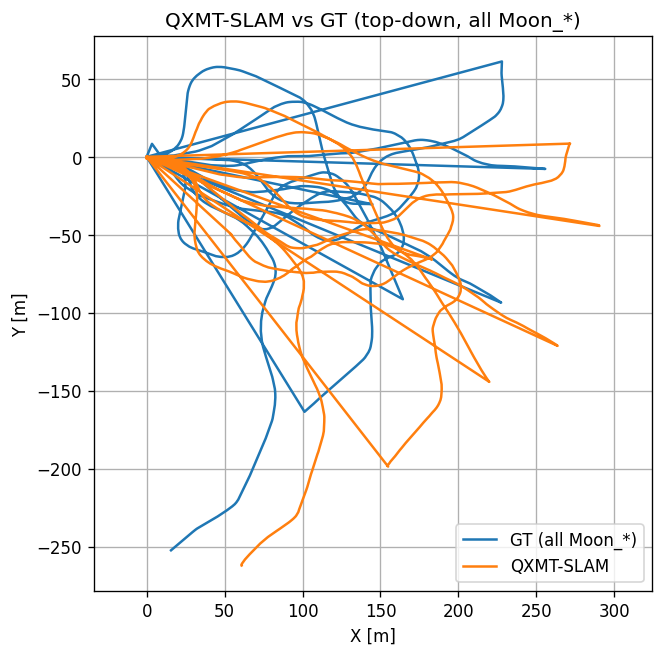

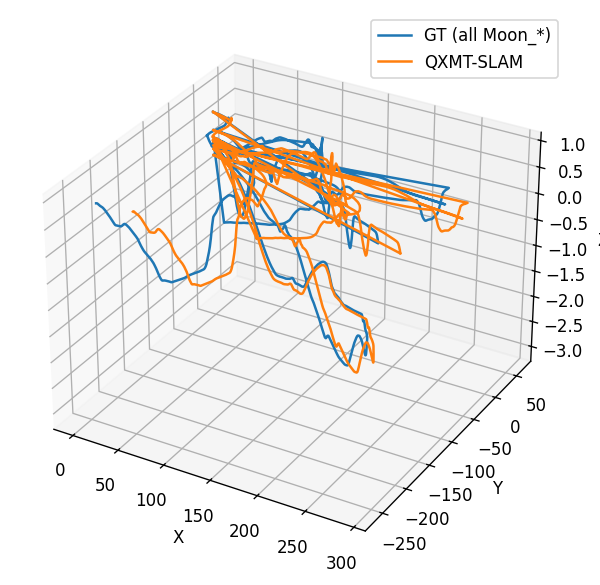

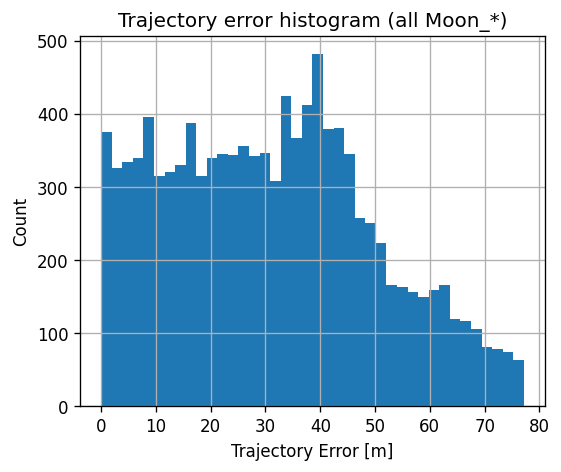

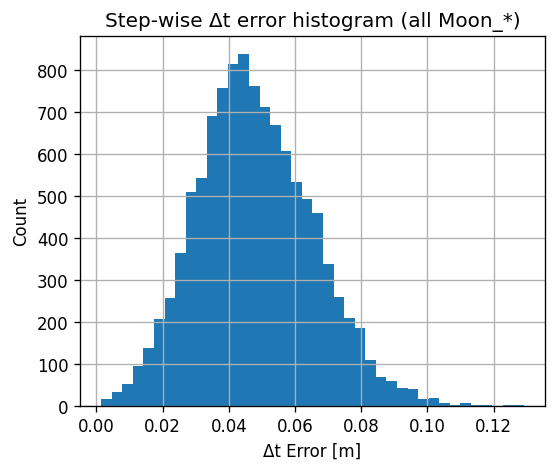

In [10]:
model.eval()

t_std_t = torch.from_numpy(t_std).to(device)

dt_pred_all = []      # list of (N_i-1,3)
dt_gt_all = []        # list of (N_i-1,3)
t_cam_all_list = []   # list of (N_i,3)

with torch.no_grad():
    for ds, color_ts, t_gt_ds, imu_feats in zip(datasets, all_color_ts, all_t_gt, all_imu_feats):
        N_i = len(color_ts)
        if N_i < 2:
            continue

        t_cam_ds = np.zeros_like(t_gt_ds)
        t_cam_ds[0] = t_gt_ds[0]

        dt_pred_list = []
        dt_gt_list = []

        for i in range(N_i - 1):
            ts_pair = [int(color_ts[i]), int(color_ts[i + 1])]

            imgs = []
            lidars = []
            imus = []

            for j, ts in enumerate(ts_pair):
                rgb = ds.load_rgb(int(ts))
                imgs.append(preprocess_image_bgr_to_tensor(rgb))

                pts = load_lidar_points(ds.lidar_dir, ts)
                if pts.shape[0] == 0:
                    sampled = np.zeros((N_POINTS, 3), dtype=np.float32)
                else:
                    if pts.shape[0] >= N_POINTS:
                        idxs = np.random.choice(pts.shape[0], N_POINTS, replace=False)
                    else:
                        idxs = np.random.choice(pts.shape[0], N_POINTS, replace=True)
                    sampled = pts[idxs]
                lidars.append(torch.from_numpy(sampled))

                imus.append(torch.from_numpy(imu_feats[i + j]))

            imgs = torch.stack(imgs, dim=0).unsqueeze(0).to(device)        # (1,2,3,H,W)
            lidars = torch.stack(lidars, dim=0).unsqueeze(0).to(device)    # (1,2,N_POINTS,3)
            imus = torch.stack(imus, dim=0).unsqueeze(0).to(device)        # (1,2,6)

            dt_norm = model(imgs, lidars, imus)[0, 0]   # (3,) normalized Δt
            dt = (dt_norm * t_std_t).cpu().numpy()      # de-normalize to meters
            dt_pred_list.append(dt)

            dt_gt = t_gt_ds[i + 1] - t_gt_ds[i]
            dt_gt_list.append(dt_gt)

            t_cam_ds[i + 1] = t_cam_ds[i] + dt

        dt_pred_i = np.stack(dt_pred_list, axis=0)   # (N_i-1,3)
        dt_gt_i = np.stack(dt_gt_list, axis=0)       # (N_i-1,3)

        dt_pred_all.append(dt_pred_i)
        dt_gt_all.append(dt_gt_i)
        t_cam_all_list.append(t_cam_ds)

# Concatenate across datasets in order
dt_pred = np.concatenate(dt_pred_all, axis=0)
dt_gt = np.concatenate(dt_gt_all, axis=0)
t_cam = np.concatenate(t_cam_all_list, axis=0)

# === RMSE metrics (global across all trajectories) ===
rmse_traj, err_traj = translation_rmse(t_cam, t_gt_all)
rmse_step_val, err_step = step_rmse(dt_pred, dt_gt)

# === Path length & step statistics (global) ===
path_len, step_lengths = trajectory_length(t_gt_all)
mean_step = float(np.mean(step_lengths)) if len(step_lengths) > 0 else 0.0

# === Percentage metrics ===
traj_rmse_pct = (rmse_traj / path_len * 100.0) if path_len > 0 else 0.0
step_rmse_pct = (rmse_step_val / mean_step * 100.0) if mean_step > 0 else 0.0

print("=== QXMT-SLAM (Camera+LiDAR+IMU) Metrics over ALL Moon_* ===")
print(f"Trajectory RMSE       : {rmse_traj:.5f} m")
print(f"Total path length     : {path_len:.5f} m")
print(f"Trajectory RMSE (%%)  : {traj_rmse_pct:.5f} % of path length")
print("---")
print(f"Step RMSE             : {rmse_step_val:.5f} m")
print(f"Mean step length      : {mean_step:.5f} m")
print(f"Step RMSE (%%)        : {step_rmse_pct:.5f} % of mean step")

# === Plots (global, concatenated trajectories) ===
plt.figure(figsize=(6, 4))
plt.plot(err_traj)
plt.xlabel("Frame (concatenated across datasets)")
plt.ylabel("Error [m]")
plt.title("QXMT-SLAM per-frame trajectory error (all Moon_*)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(err_step)
plt.xlabel("Step (concatenated across datasets)")
plt.ylabel("Δt Error [m]")
plt.title("QXMT-SLAM per-step Δt error (all Moon_*)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(t_gt_all[:, 0], t_gt_all[:, 1], label="GT (all Moon_*)")
plt.plot(t_cam[:, 0], t_cam[:, 1], label="QXMT-SLAM")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("QXMT-SLAM vs GT (top-down, all Moon_*)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(t_gt_all[:, 0], t_gt_all[:, 1], t_gt_all[:, 2], label="GT (all Moon_*)")
ax.plot(t_cam[:, 0], t_cam[:, 1], t_cam[:, 2], label="QXMT-SLAM")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(err_traj, bins=40)
plt.xlabel("Trajectory Error [m]")
plt.ylabel("Count")
plt.title("Trajectory error histogram (all Moon_*)")
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(err_step, bins=40)
plt.xlabel("Δt Error [m]")
plt.ylabel("Count")
plt.title("Step-wise Δt error histogram (all Moon_*)")
plt.grid(True)
plt.show()

In [11]:
out_dir = Path("~/experiment/lusnar_slam/results_qxmt_slam").expanduser()
out_dir.mkdir(parents=True, exist_ok=True)

np.save(out_dir / "t_gt_all.npy", t_gt_all)
np.save(out_dir / "t_cam_qxmt.npy", t_cam)
np.save(out_dir / "err_traj_qxmt.npy", err_traj)
np.save(out_dir / "err_step_qxmt.npy", err_step)
np.savez(out_dir / "metrics_qxmt_multi.npz",
         rmse_traj=rmse_traj,
         rmse_step=rmse_step_val,
         traj_rmse_pct=traj_rmse_pct,
         step_rmse_pct=step_rmse_pct,
         path_len=path_len,
         mean_step=mean_step,
         num_frames=t_gt_all.shape[0])

torch.save(model.state_dict(), out_dir / "qxmt_slam_net.pth")

print("Saved QXMT-SLAM multi-modal results and model to", out_dir)

Saved QXMT-SLAM multi-modal results and model to /home/gurman_preet_526_gmail_com/experiment/lusnar_slam/results_qxmt_slam


Loaded saved inference results.

Scene sizes: [1094, 1597, 1230, 1320, 1599, 1102, 1626, 1351]
Cumulative index: [ 1094  2691  3921  5241  6840  7942  9568 10919]

================ PER-SCENE METRICS ================

Scene Moon_1:
  Trajectory RMSE       = 29.237 m
  Trajectory RMSE (%%)  = 11.20 %
  Step RMSE             = 0.049 m



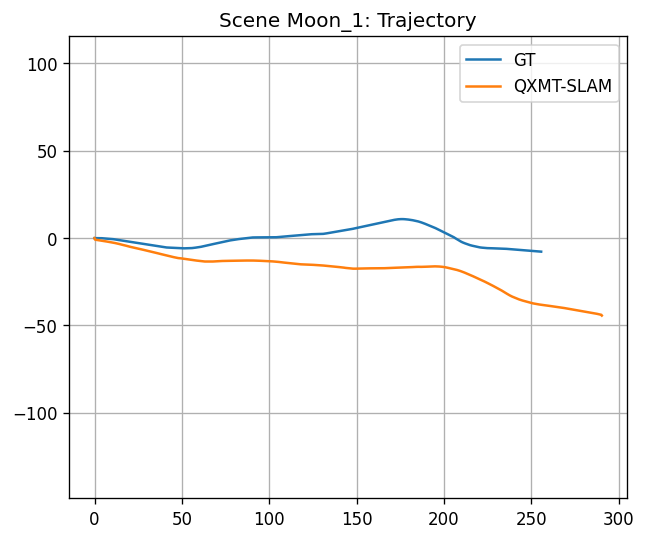

Scene Moon_2:
  Trajectory RMSE       = 39.389 m
  Trajectory RMSE (%%)  = 11.51 %
  Step RMSE             = 0.046 m



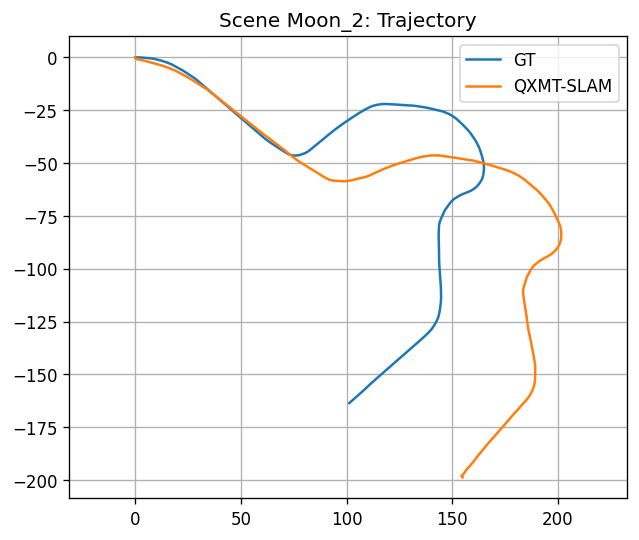

Scene Moon_3:
  Trajectory RMSE       = 26.891 m
  Trajectory RMSE (%%)  = 10.51 %
  Step RMSE             = 0.045 m



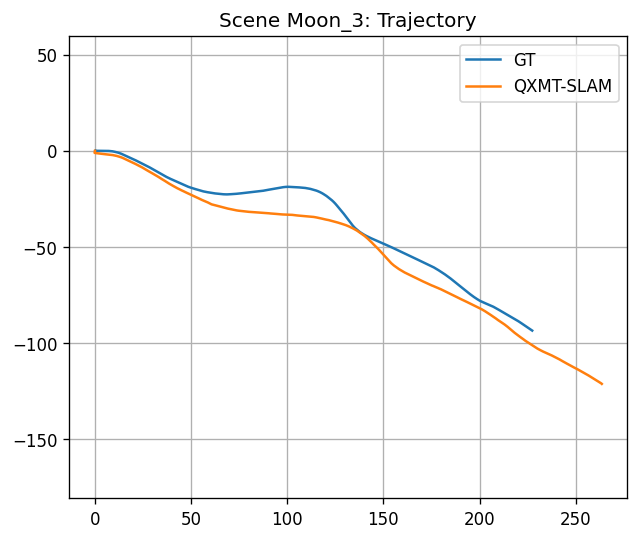

Scene Moon_4:
  Trajectory RMSE       = 36.231 m
  Trajectory RMSE (%%)  = 12.51 %
  Step RMSE             = 0.057 m



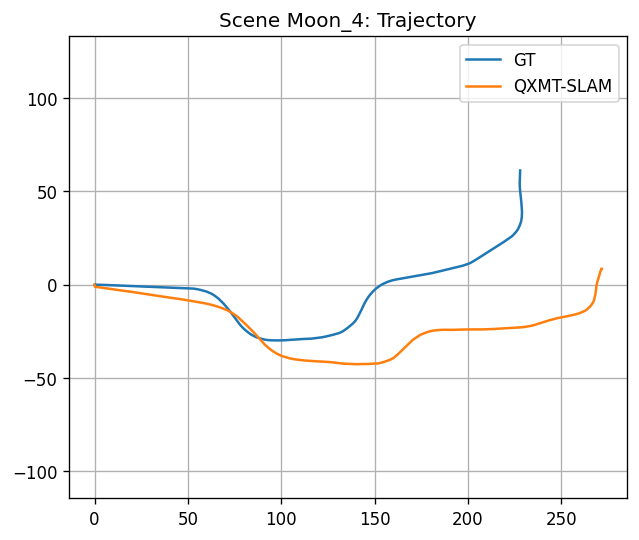

Scene Moon_5:
  Trajectory RMSE       = 40.962 m
  Trajectory RMSE (%%)  = 9.87 %
  Step RMSE             = 0.058 m



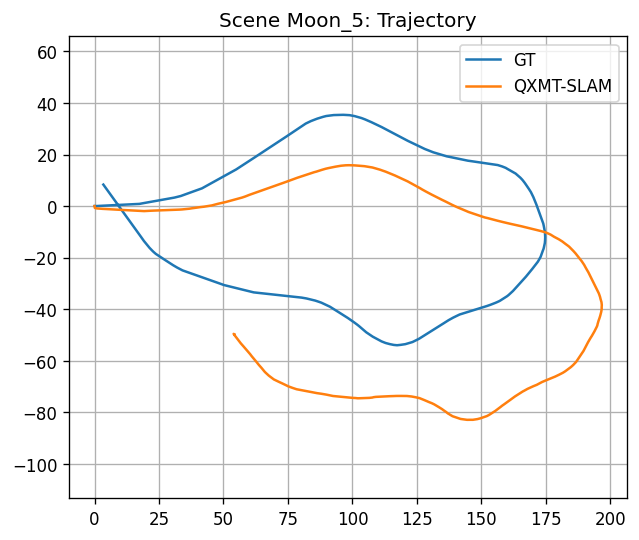

Scene Moon_6:
  Trajectory RMSE       = 33.433 m
  Trajectory RMSE (%%)  = 14.31 %
  Step RMSE             = 0.056 m



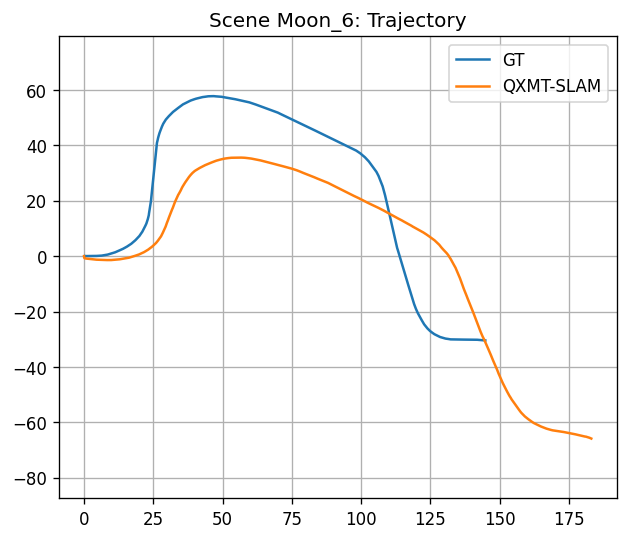

Scene Moon_7:
  Trajectory RMSE       = 46.075 m
  Trajectory RMSE (%%)  = 15.91 %
  Step RMSE             = 0.054 m



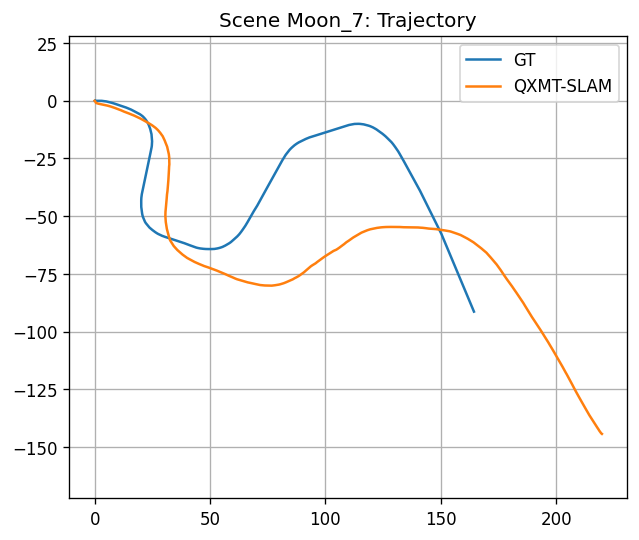

Scene Moon_8:
  Trajectory RMSE       = 28.113 m
  Trajectory RMSE (%%)  = 8.60 %
  Step RMSE             = 0.040 m



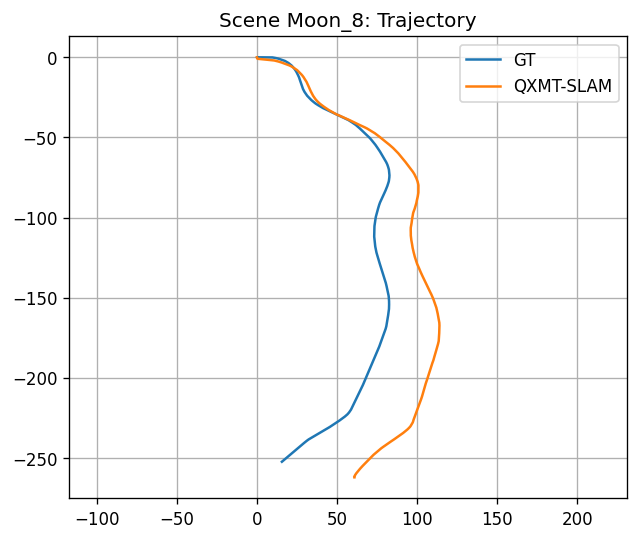


================ GLOBAL METRICS ================

Trajectory RMSE       : 36.403 m
Trajectory RMSE (%%)  : 0.99 %
Step RMSE             : 1.602 m
Step RMSE (%%)        : 473.98 %


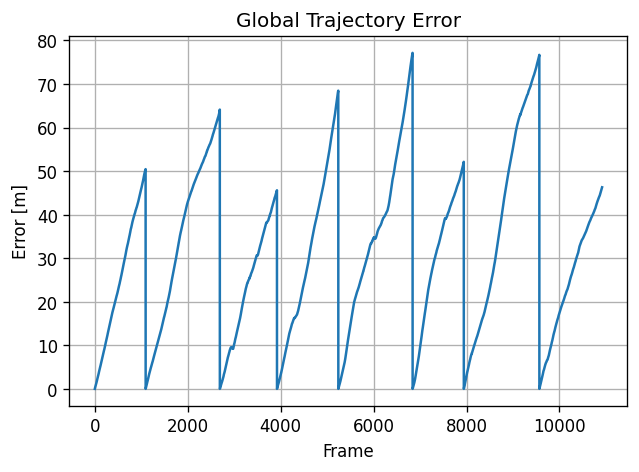

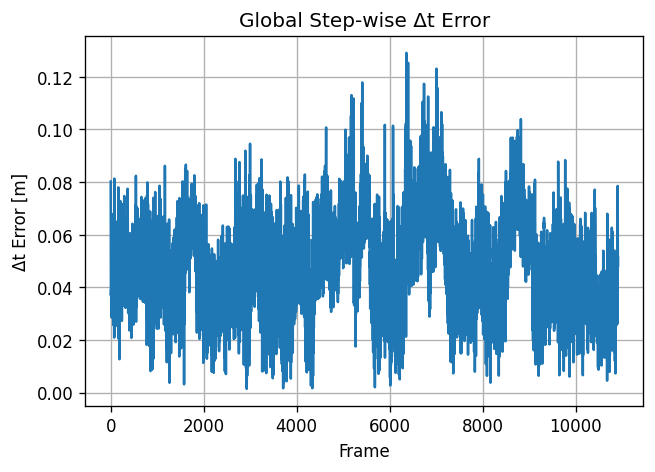

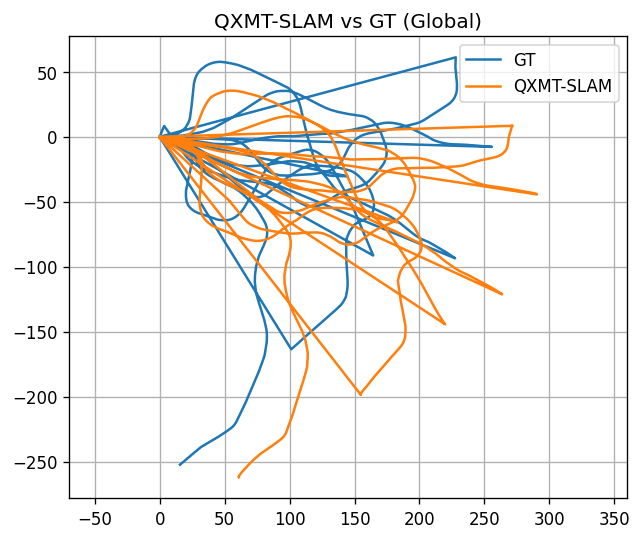

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------
# Load saved results
# -------------------------------
results_dir = Path("~/experiment/lusnar_slam/results_qxmt_slam").expanduser()

t_gt_all = np.load(results_dir / "t_gt_all.npy")
t_cam_all = np.load(results_dir / "t_cam_qxmt.npy")
err_traj_all = np.load(results_dir / "err_traj_qxmt.npy")
err_step_all = np.load(results_dir / "err_step_qxmt.npy")
meta = np.load(results_dir / "metrics_qxmt_multi.npz")

print("Loaded saved inference results.")

# =========================================================
#  Basic metric helpers
# =========================================================
def translation_rmse(pred, gt):
    diff = pred - gt
    err = np.linalg.norm(diff, axis=1)
    return float(np.sqrt(np.mean(err ** 2))), err

def step_rmse(dt_pred, dt_gt):
    diff = dt_pred - dt_gt
    err = np.linalg.norm(diff, axis=1)
    return float(np.sqrt(np.mean(err ** 2))), err

def trajectory_length(gt):
    if gt.shape[0] < 2:
        return 0.0, np.array([])
    diffs = gt[1:] - gt[:-1]
    seg = np.linalg.norm(diffs, axis=1)
    return float(np.sum(seg)), seg

# =========================================================
#  Reconstruct per-scene splits from original dataset sizes
# =========================================================
scene_sizes = [len(ds) for ds in all_color_ts]   # you already have all_color_ts loaded in notebook
scene_cumsum = np.cumsum(scene_sizes)

print("\nScene sizes:", scene_sizes)
print("Cumulative index:", scene_cumsum)

# =========================================================
#  PER-SCENE EVALUATION
# =========================================================
print("\n================ PER-SCENE METRICS ================\n")

start_idx = 0
scene_metrics = []

for scene_id, (ds, size) in enumerate(zip(datasets, scene_sizes), start=1):

    end_idx = start_idx + size

    # Extract per-scene GT and predicted trajectory
    gt_scene = t_gt_all[start_idx:end_idx]
    cam_scene = t_cam_all[start_idx:end_idx]

    # Build per-step GT and predictions
    dt_pred_scene = cam_scene[1:] - cam_scene[:-1]
    dt_gt_scene = gt_scene[1:] - gt_scene[:-1]

    rmse_traj, _ = translation_rmse(cam_scene, gt_scene)
    rmse_step, _ = step_rmse(dt_pred_scene, dt_gt_scene)

    path_len, _ = trajectory_length(gt_scene)
    traj_pct = rmse_traj / path_len * 100 if path_len > 0 else 0.0

    scene_name = ds.root.name

    scene_metrics.append((scene_name, rmse_traj, traj_pct, rmse_step))

    print(f"Scene {scene_name}:")
    print(f"  Trajectory RMSE       = {rmse_traj:.3f} m")
    print(f"  Trajectory RMSE (%%)  = {traj_pct:.2f} %")
    print(f"  Step RMSE             = {rmse_step:.3f} m\n")

    # ----- Store plots -----
    plt.figure(figsize=(6,5))
    plt.plot(gt_scene[:,0], gt_scene[:,1], label="GT")
    plt.plot(cam_scene[:,0], cam_scene[:,1], label="QXMT-SLAM")
    plt.title(f"Scene {scene_name}: Trajectory")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()

    start_idx = end_idx

# =========================================================
#  GLOBAL METRICS (already computed, but recomputed for safety)
# =========================================================
print("\n================ GLOBAL METRICS ================\n")

rmse_traj_global, _ = translation_rmse(t_cam_all, t_gt_all)
rmse_step_global, _ = step_rmse(
    t_cam_all[1:] - t_cam_all[:-1],
    t_gt_all[1:] - t_gt_all[:-1]
)

path_len_global, step_lengths_global = trajectory_length(t_gt_all)
mean_step_len = np.mean(step_lengths_global)

print(f"Trajectory RMSE       : {rmse_traj_global:.3f} m")
print(f"Trajectory RMSE (%%)  : {rmse_traj_global/path_len_global*100:.2f} %")
print(f"Step RMSE             : {rmse_step_global:.3f} m")
print(f"Step RMSE (%%)        : {rmse_step_global/mean_step_len*100:.2f} %")

# =========================================================
#  GLOBAL PLOTS
# =========================================================

plt.figure(figsize=(6,4))
plt.plot(err_traj_all)
plt.title("Global Trajectory Error")
plt.xlabel("Frame")
plt.ylabel("Error [m]")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(err_step_all)
plt.title("Global Step-wise Δt Error")
plt.xlabel("Frame")
plt.ylabel("Δt Error [m]")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.plot(t_gt_all[:,0], t_gt_all[:,1], label="GT")
plt.plot(t_cam_all[:,0], t_cam_all[:,1], label="QXMT-SLAM")
plt.title("QXMT-SLAM vs GT (Global)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()
